Predicted Skin Tone: Olive


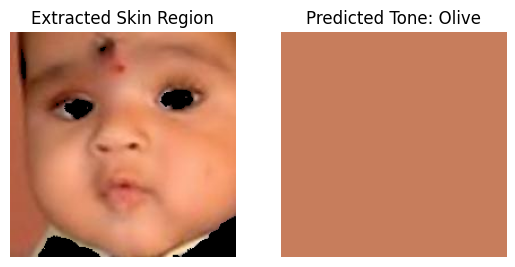

In [6]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def extract_skin(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define skin color range in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Create a mask
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Extract skin region
    skin = cv2.bitwise_and(image, image, mask=mask)
    return skin


def get_dominant_color(image, k=1):
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((-1, 3))

    # Remove black pixels (background noise)
    image = image[np.any(image != [0, 0, 0], axis=1)]

    # Apply KMeans clustering to find dominant color
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(image)

    return kmeans.cluster_centers_[0]


def match_skin_tone(rgb_color):
    # Custom Skin Tone Categories
    skin_tones = {
        "Very Fair": (255, 224, 189),
        "Fair": (255, 205, 160),
        "Medium": (240, 180, 140),
        "Olive": (210, 150, 110),
        "Brown": (150, 100, 75),
        "Dark Brown": (90, 60, 45),
    }

    # Find the closest skin tone using Euclidean distance
    min_distance = float("inf")
    best_match = None
    for tone, color in skin_tones.items():
        distance = np.linalg.norm(np.array(rgb_color) - np.array(color))
        if distance < min_distance:
            min_distance = distance
            best_match = tone

    return best_match


def predict_skin_tone(image_path):
    image = cv2.imread(image_path)
    skin = extract_skin(image)
    dominant_color = get_dominant_color(skin)
    skin_tone = match_skin_tone(dominant_color)

    print(f"Predicted Skin Tone: {skin_tone}")

    # Display the extracted skin region and dominant color
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
    plt.title("Extracted Skin Region")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow([[dominant_color / 255]])
    plt.title(f"Predicted Tone: {skin_tone}")
    plt.axis("off")
    plt.show()
    
# Main function
if __name__ == "__main__":
    predict_skin_tone("test_brown2.jpg")
